# Demo: Implementing the circuit optimization procedures introduced in "Automated optimization of large quantum circuits with continuous parameters" by Nam et al.

Import the necessary packages. `converters` has converting utilities which allow to construct a QuantumCircuit from a given file in .qc format. `optimizations` include the first three optimization procedures from the Light Optimization.

In [1]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import Statevector

import converters
from optimizations import RzReduction, HGateReduction, CxReduction

First, we convert the input `vbe_adder_3_before` into a QuantumCircuit. The VBE adder looks like this before any optimization step occurs:
![vbe-adder](inputs/vbe_adder.png)

The controlled-Z gates need to be converted into 'allowed' circuit gates through the Toffoli transformation (Hadamard gates need to be added before and after each Z gate to perform a Toffoli transformation):
![toffoli-equivalence](inputs/toffoli-transformation.png)

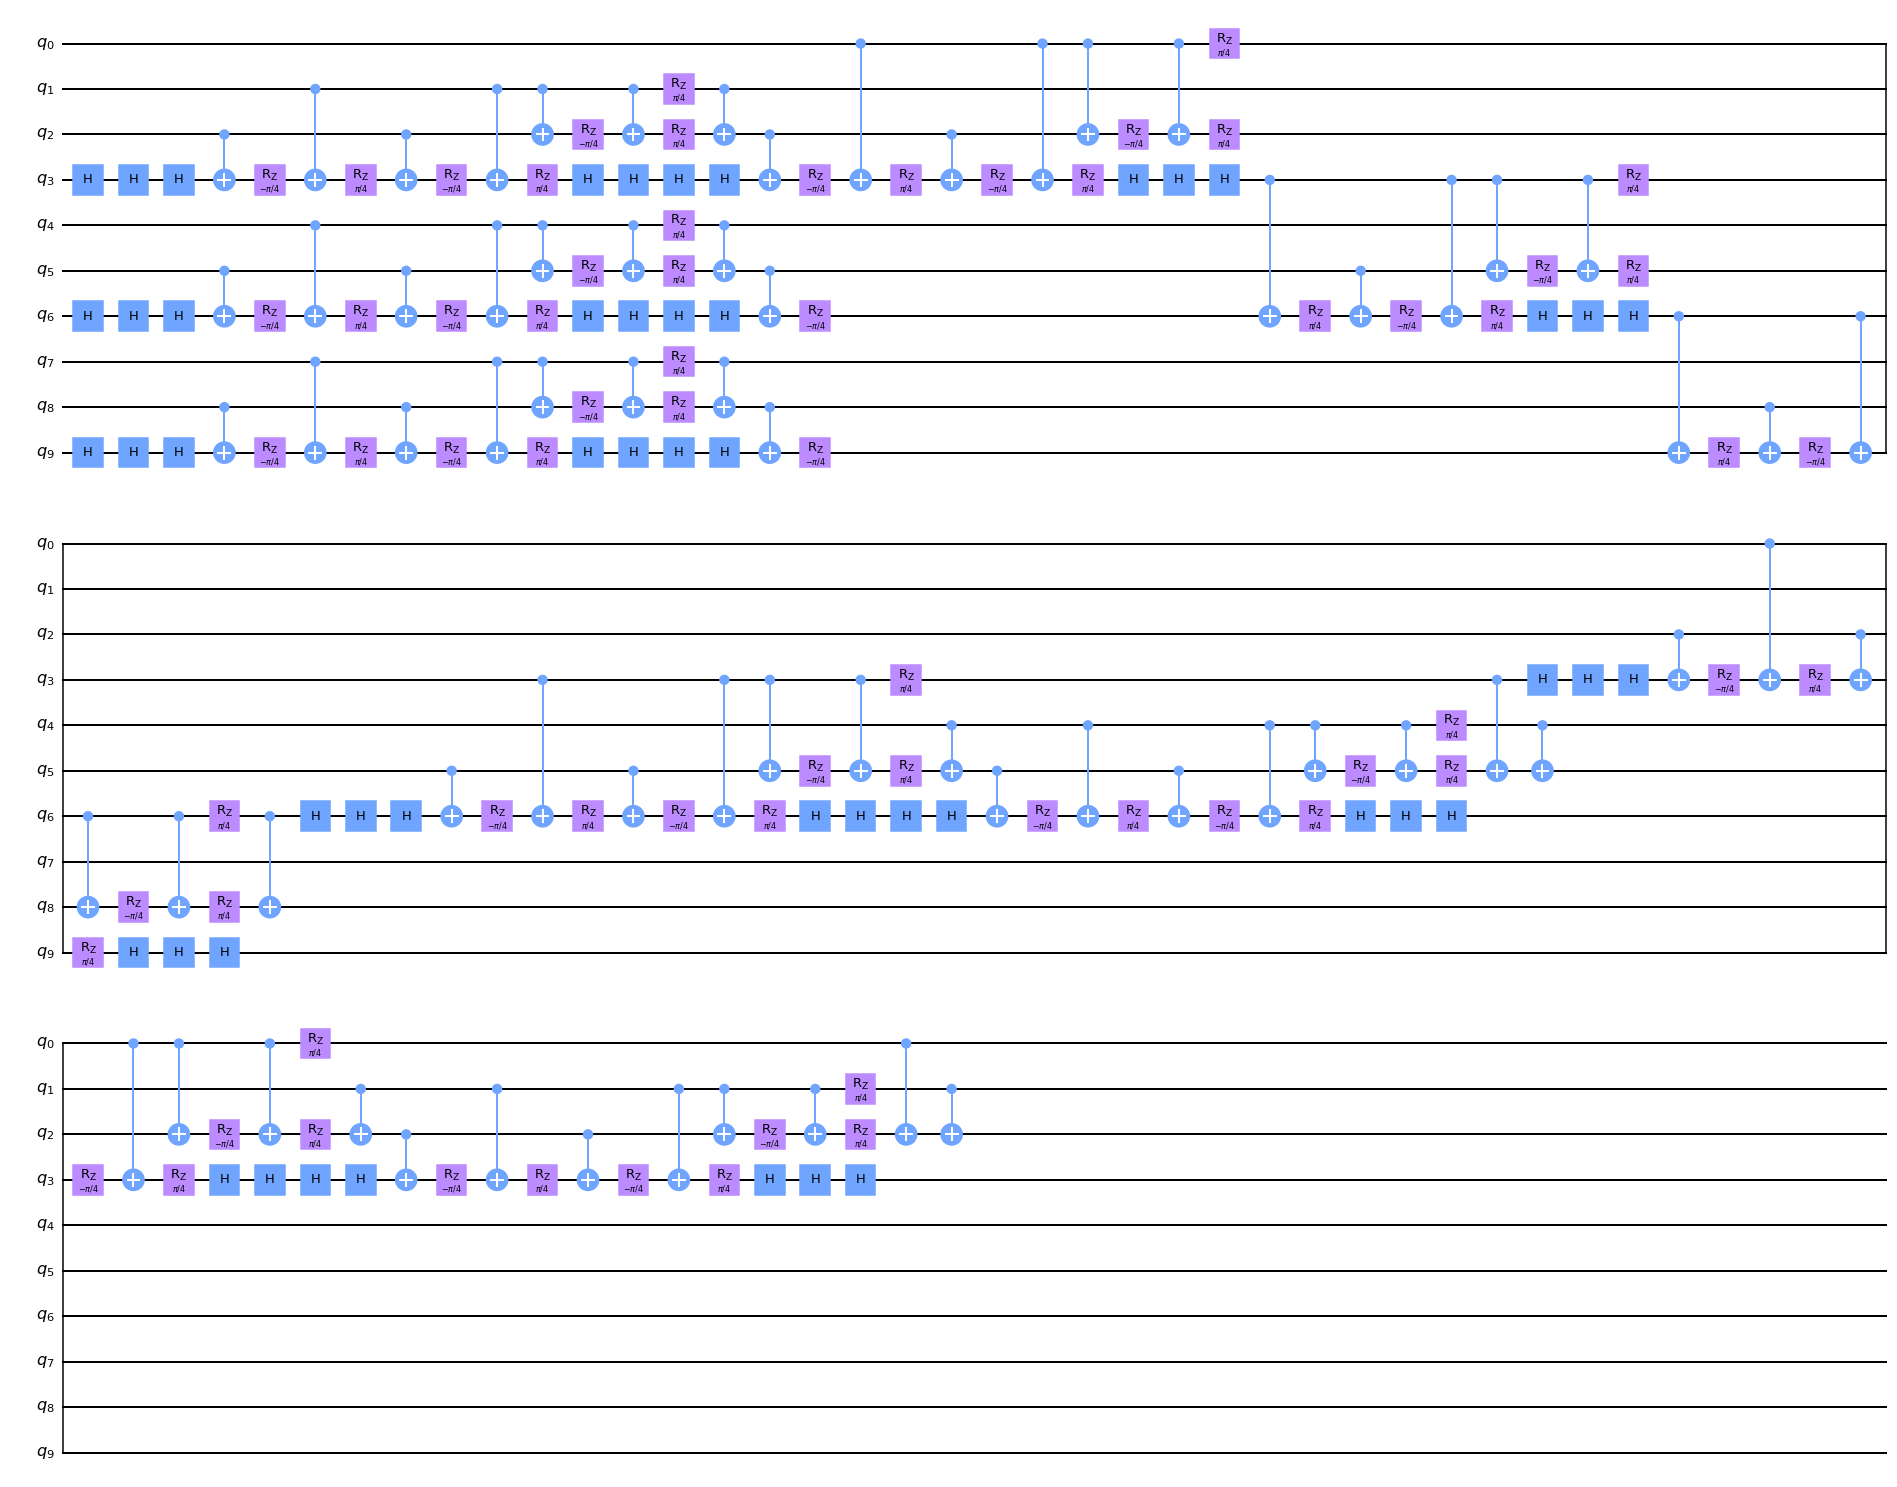

In [2]:
# Convert the input to a quantum circuit
parser = converters.Parser('./inputs/vbe_adder_3_before')
netlist = parser.qc_to_netlist()
input_qc = parser.netlist_to_qiskit_circuit(netlist)
input_qc.draw(output="mpl", fold=40)

In [3]:
dag = circuit_to_dag(input_qc)
dag.count_ops()

{'h': 50, 'cx': 70, 'rz': 70}

## 1. Hadamard Gate Reductions

We reduce the number of Hadamard gates by the following equivalences:
![hadamard-reductions](inputs/h_reductions.png)

We also cancel any neighbouring Hadamard gates along the way.

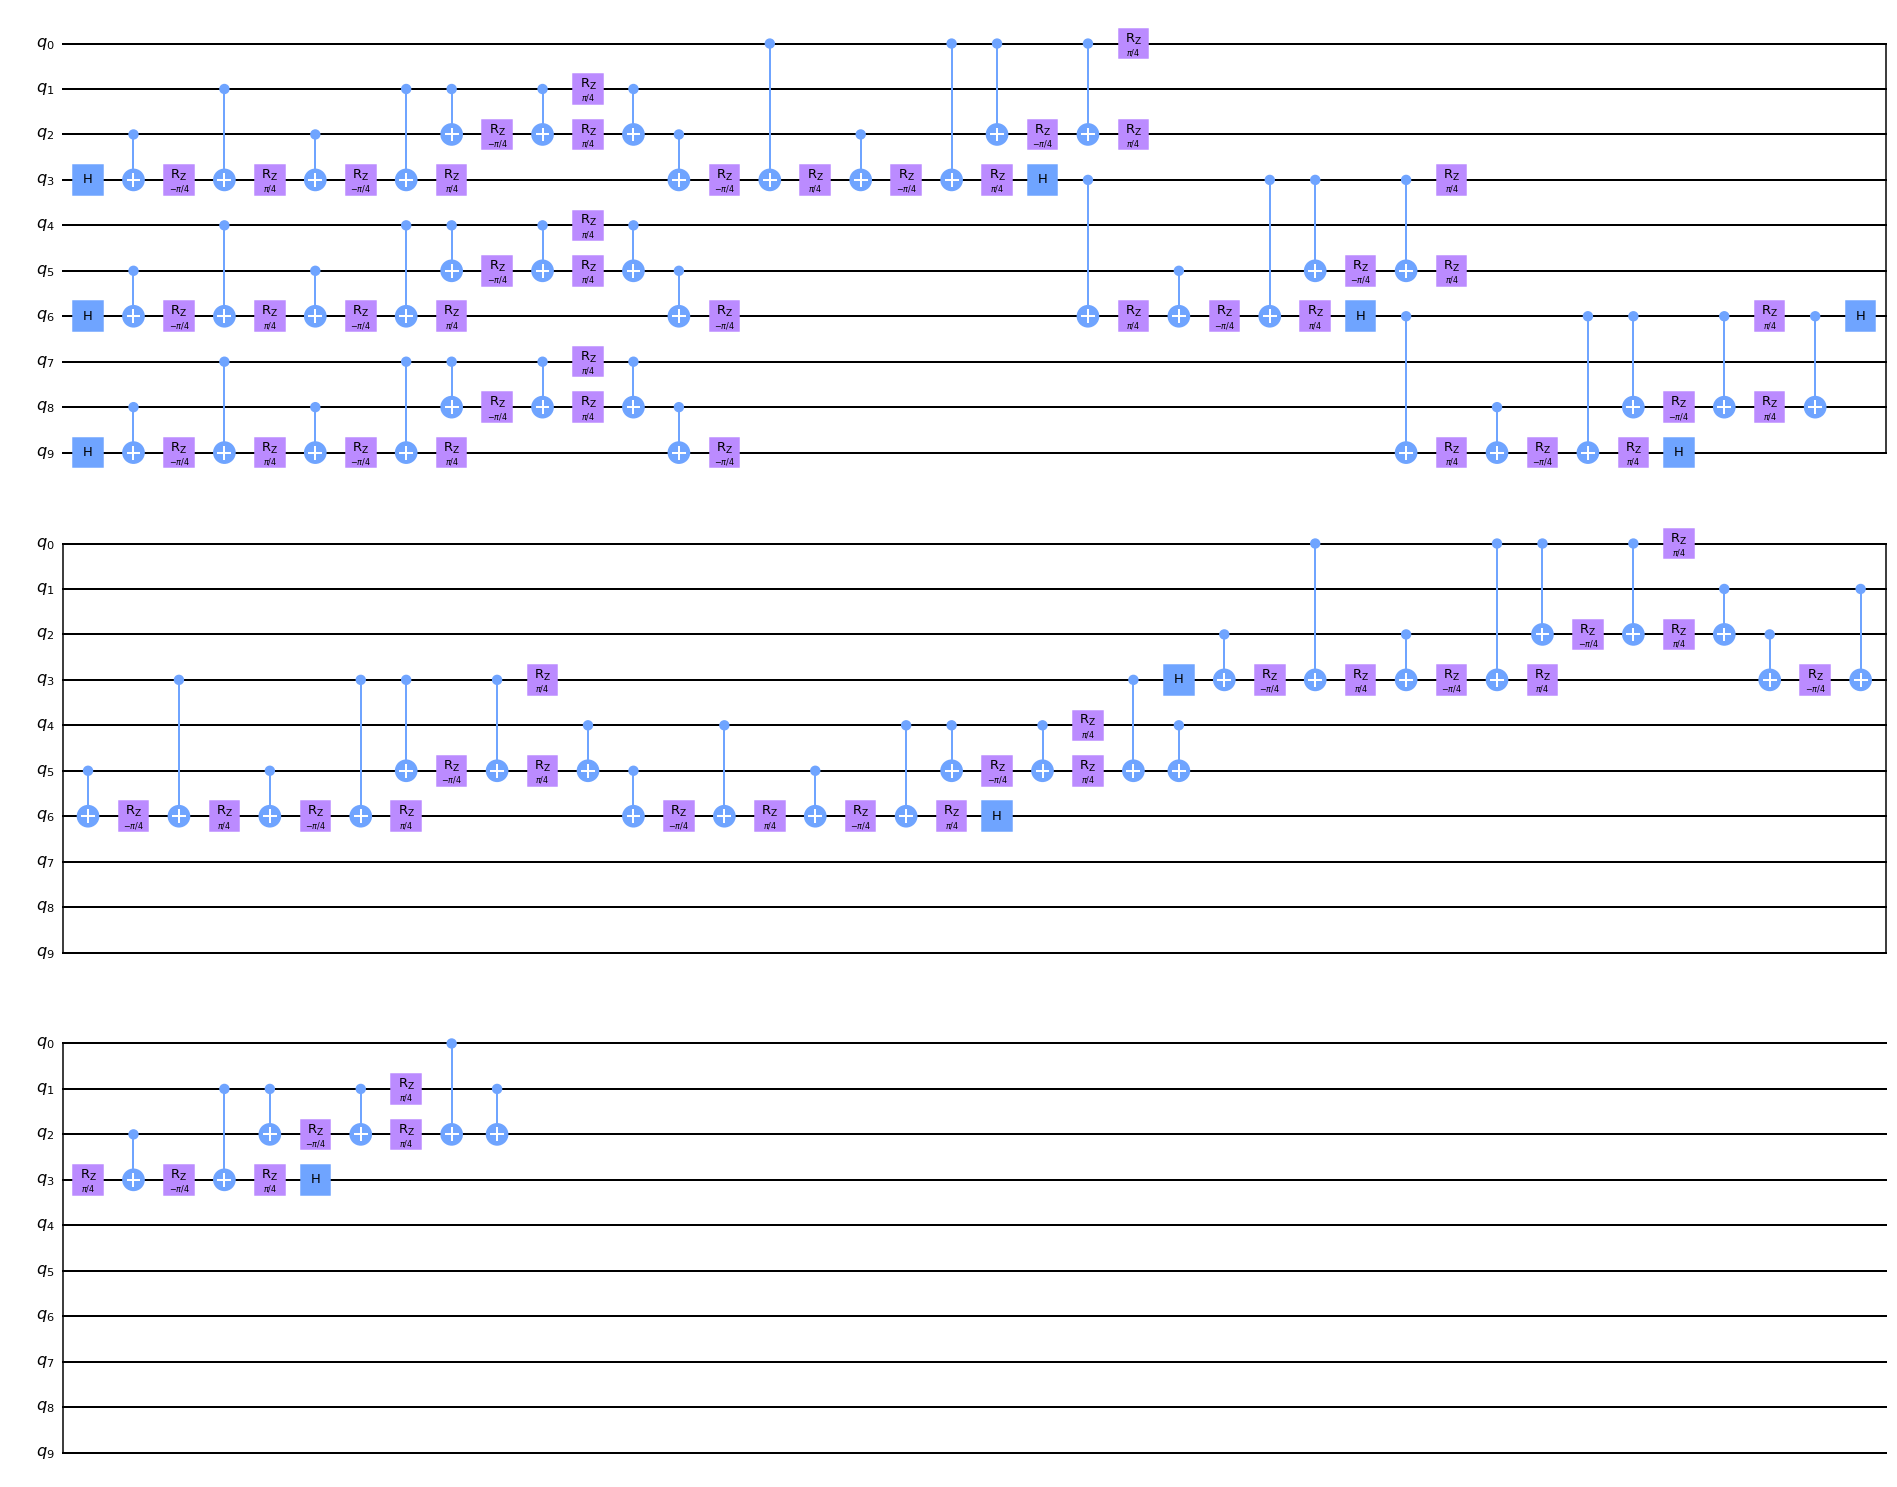

In [4]:
# Apply the Hadamard Gate Reduction
reduction = HGateReduction(circuit_to_dag(input_qc))
dag = reduction.apply()
qc = dag_to_circuit(dag)
qc.draw(output="mpl", fold=40)

In [5]:
reduction.report()

Reduced the number of h gates by 40 (Before reduction: 50, After reduction: 10)



## 2. Rz-Gate Reduction

We try to commute the rotation gates by the Z-axis through the wires to merge them with other rotation gates. The rotation gates may cancel each other out or simply add up. If a commutation is not successful, the gates are kept at their initial positions. Instead of trying to commute through every gate sequence, we use the following commutation rules:
![rz_rules.png](inputs/rz_rules.png)

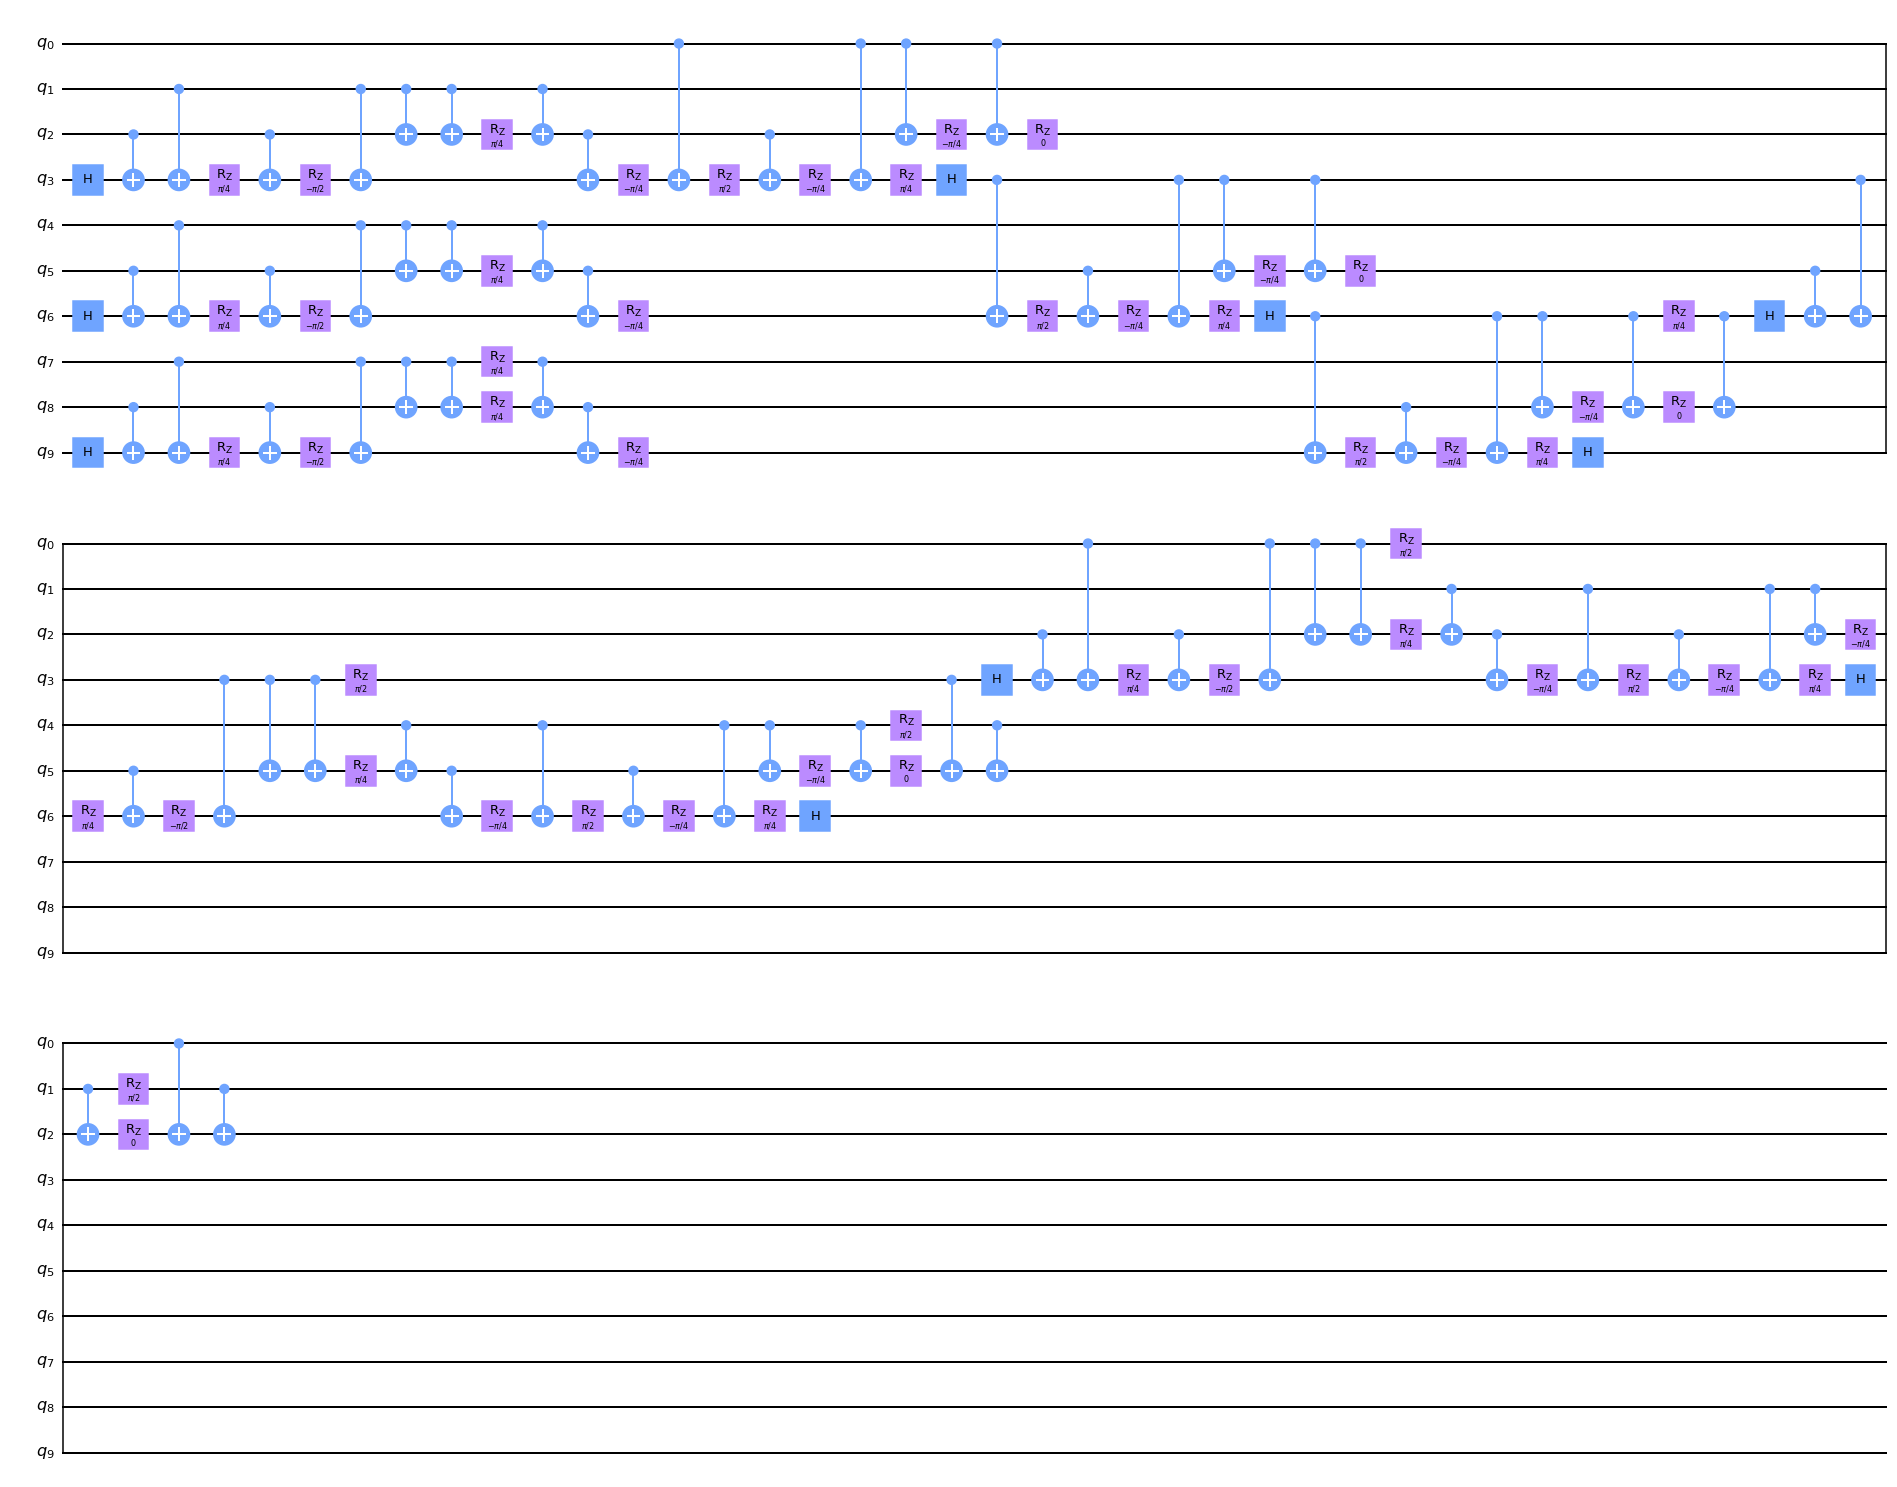

In [6]:
# Apply the Rz-Gate Reduction
reduction = RzReduction(circuit_to_dag(qc))
dag = reduction.apply()
qc = dag_to_circuit(dag)
qc.draw(output="mpl", fold=40)

In [7]:
reduction.report()

Reduced the number of rz gates by 19 (Before reduction: 70, After reduction: 51)



## 3. Cx Reduction

The logic is the same as the Rz Gate Reduction: Trying to cancel out adjacent CNOT gates through commutation rules.
![cx_rules.png](inputs/cx_rules.png)

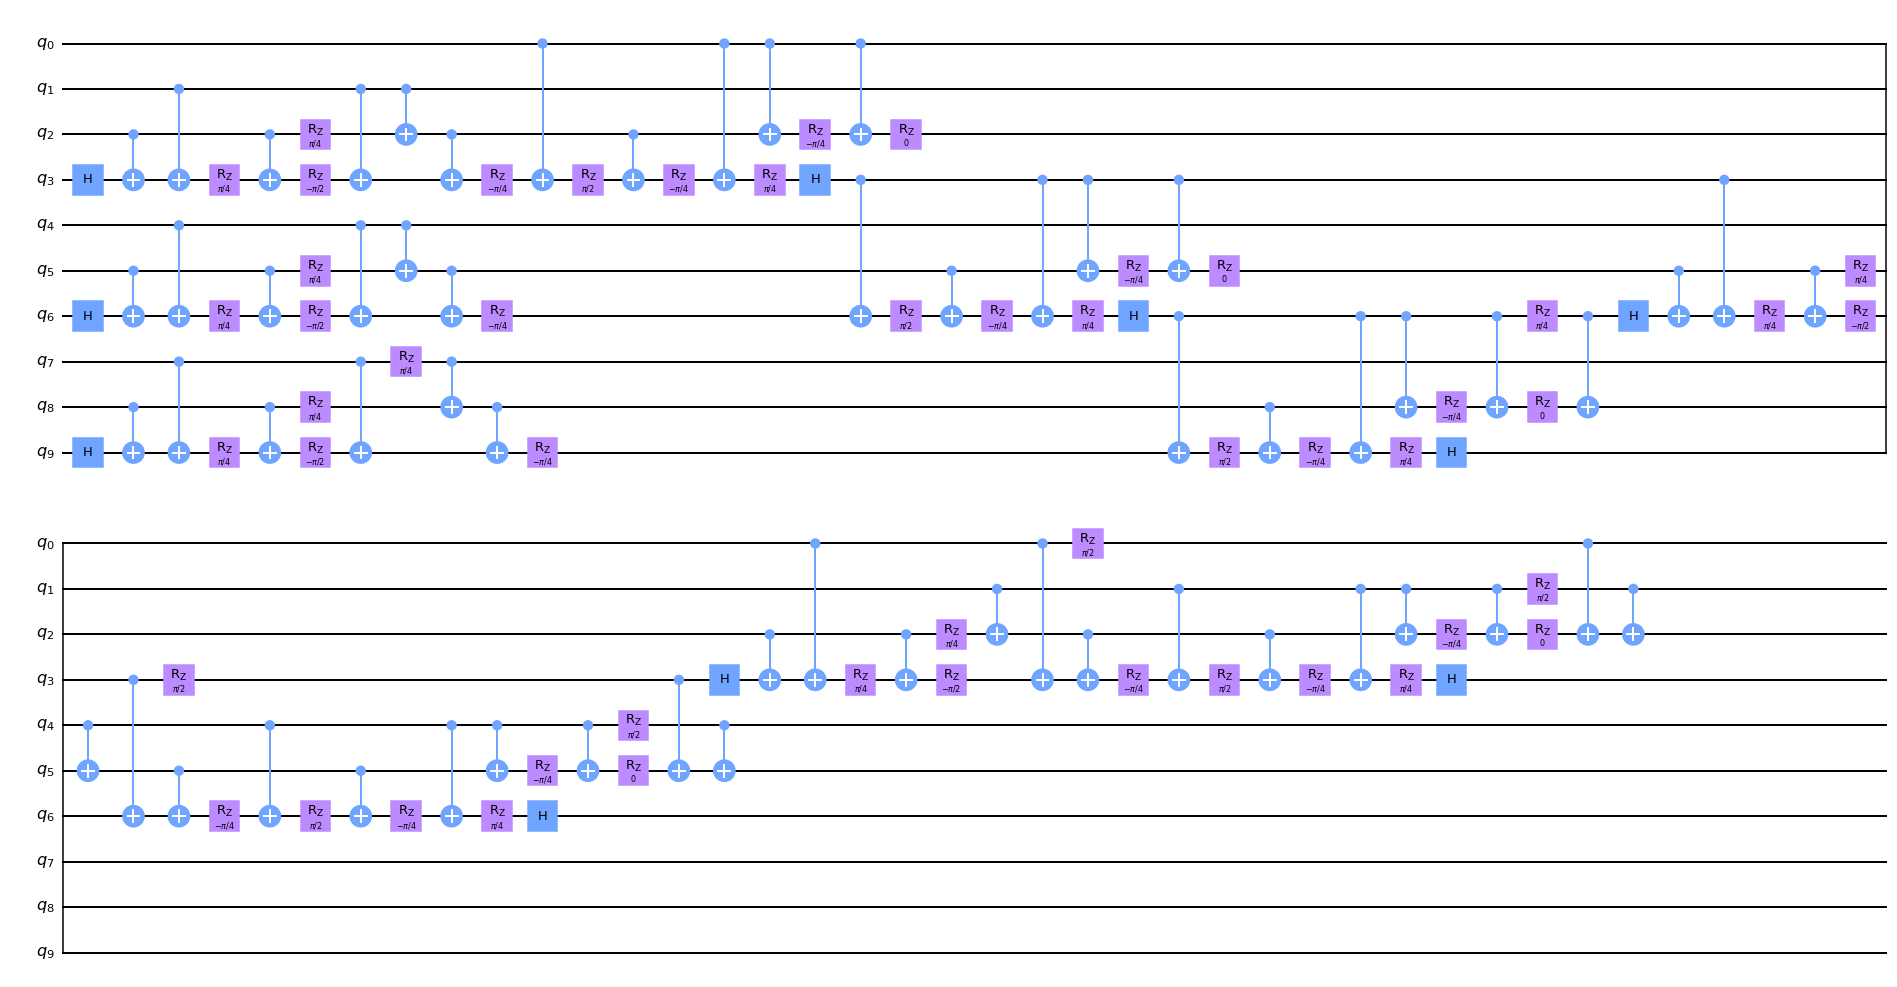

In [8]:
# Apply the CNOT Gate Reduction
reduction = CxReduction(circuit_to_dag(qc))
dag = reduction.apply()
qc = dag_to_circuit(dag)
qc.draw(output="mpl", fold=40)

In [9]:
reduction.report()

Reduced the number of cx gates by 10 (Before reduction: 70, After reduction: 60)



In fact, as suggested in the paper, we can run the reductions several times to get better results:

In [10]:
# Preserving the order presented in the paper
routine_dic = {1: "HGateReduction", 2: "RzReduction", 3: "CxReduction"}
light_optimization = [1, 3, 2, 3, 1, 2, 3, 2]

# Apply the optimization procedure
for i in range(3):
    for routine in light_optimization:
        klass = globals()[routine_dic[routine]]
        reduction = klass(dag)
        dag = reduction.apply()
        reduction.report()

Reduced the number of rz gates by 7 (Before reduction: 51, After reduction: 44)

Reduced the number of cx gates by 10 (Before reduction: 60, After reduction: 50)

Reduced the number of rz gates by 7 (Before reduction: 44, After reduction: 37)

Reduced the number of cx gates by 4 (Before reduction: 50, After reduction: 46)

Reduced the number of rz gates by 5 (Before reduction: 37, After reduction: 32)

Reduced the number of cx gates by 10 (Before reduction: 46, After reduction: 36)

Reduced the number of rz gates by 2 (Before reduction: 32, After reduction: 30)

Reduced the number of cx gates by 4 (Before reduction: 36, After reduction: 32)

Reduced the number of rz gates by 2 (Before reduction: 30, After reduction: 28)



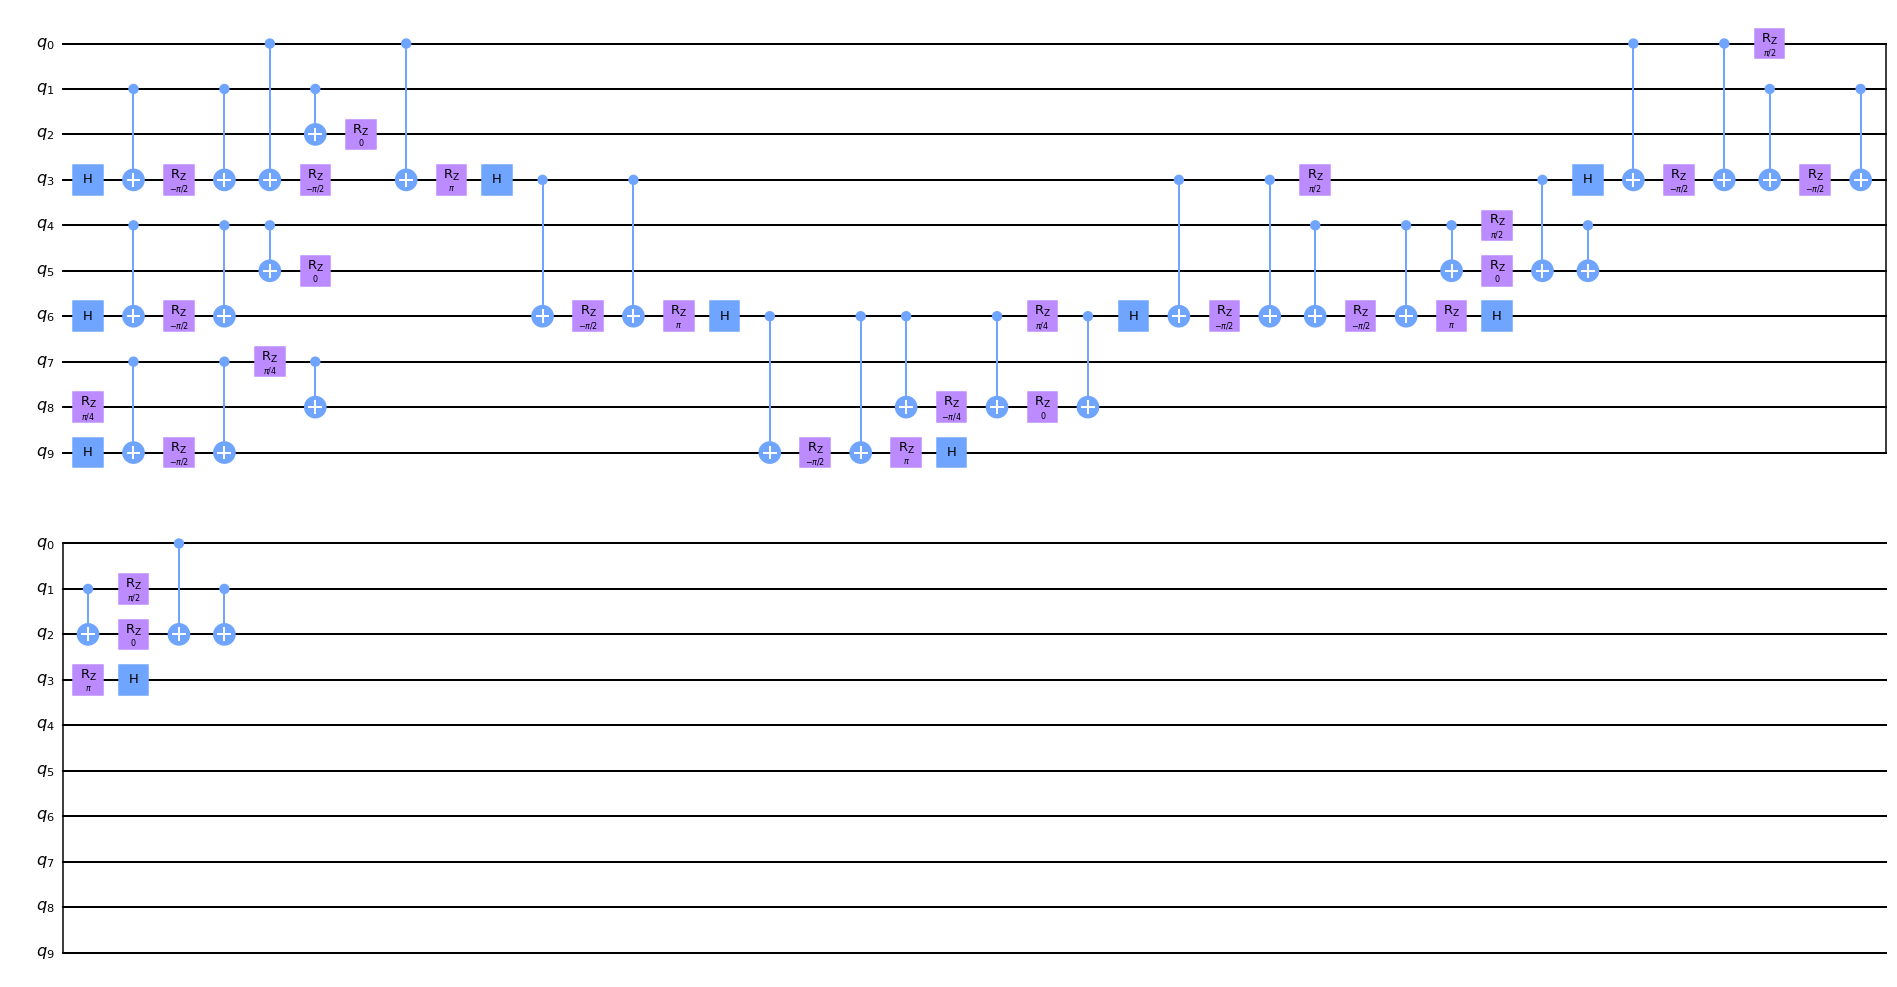

In [11]:
optimized_qc = dag_to_circuit(dag)
optimized_qc.draw(output="mpl", fold=40)

In [12]:
dag.count_ops()

{'h': 10, 'cx': 32, 'rz': 28}

Let's look at the gate counts before and after the reductions:

| Gate | Pre-Optimization Count | Post-Optimization Count |
| --- | --- | --- |
| H | 50 | 10 |
| CNOT | 70 | 32 |
| Rz | 70 | 28 |

Finally, we make sure that the state-vector representing the optimal circuit is indeed the same as the initial state-vector of the circuit:

In [13]:
Statevector.from_instruction(input_qc).equiv(Statevector.from_instruction(optimized_qc))

True